# Greeble data preprocessing and dimension reduction

Right now I only have 160 greeble images in the *data* directory on my repository. Each greeble has over 100,000 pixels - if we want to be able to classify greebles as male or female, our problem is wayyyy underdetermined (more features than observations). Therefore, we'll explore principal component analysis and non-negative matrix factorization to help us reduce the column rank of our dataset. Along the way, we'll explore what exactly PCA and NMF are getting us - new basis vectors to express our dataset!

In later posts, we'll use a variety of different binary classification models to help predict greeble gender.

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import hickle as hkl
import cv2
from os import listdir, path, getcwd
import re
from sklearn import preprocessing

## Set wd such that the data directory is a child directory
cwd = getcwd()

## Assembling the data, preprocessing...

Each greeble is a (360, 320) image, a matrix of pixels, so in order to stack them together, we'll unravel each matrix into a vector of 115200 pixels. Then our data matrix, $X$, will have one greeble per row. Similarly, our label vector, $Y $, will be comprised of 160 0's and 1's (0 indicates a female greeble, 1 indicates a male greeble).

Although the greebles are technically purple, we'll just load in grayscale versions of them for computational simplicity (convolutional neural nets are some of the only models that I've heard of where you wouldn't just default to a grayscale image). Each pixel can range from 0 (dark) to 255 (light), and we'll divide everything by 255 so that pixel intensities go from 0 to 1.

Our data matrix, $X$ will have dimensions (160, 115200). AH! This is an $n << p$ type problem, i.e. we have way more features (the pixel value at each pixel location is technically a different 'feature'), so it will be in our best interest to use some sort of matrix factorization technique to reduce the column rank of our data matrix prior to fitting some type of class discriminating model.

In [14]:
# Get greeble filepaths
greeble_imgs = listdir(path.join(cwd, "data", "greebles"))

# Get sample size, image dimension information
n = len(greeble_imgs)
greeble_0 = cv2.imread(path.join(cwd, "data", "greebles", greeble_imgs[0]), cv2.IMREAD_GRAYSCALE)
img_dim = greeble_0.shape
num_pix = greeble_0.ravel().shape[0]

# Initialize greeble image data storage
X = np.zeros([len(greeble_imgs), num_pix])

# Read, reshape, and scale greebles; store each one in a row of X.
for i in range(n):
    X[i,:] = cv2.imread(path.join(cwd, "data", "greebles", greeble_imgs[i]), cv2.IMREAD_GRAYSCALE).ravel()/255

# Obtain greeble genders: female == 0, male == 1.
Y = np.array(map(lambda x: int(re.search("^f", x) is None), greeble_imgs))

# Initialize greeble image data storage, and de-mean the data (for use with SVD).
mean_vec = X.mean(axis = 0)
X_sc = preprocessing.scale(X, with_std = False)

## Relationship between the SVD and PCA

There are two ways to find principal components and this low-dimensional representation of your data that you're after: find the eigendecomposition of the covariance matrix of $X$, or find the singular value decomposition of $X-\bar{\mu}$, where $\bar{\mu}$ is a vector of the column-means of $X$. I prefer using the SVD method, in particular because I've encountered instances where I get negative eigenvalues occurring when the true eigenvalue is on the order of machine epsilon (like 1e-15), whereas singular values are always positive.

Here's the deal: $$X = U\Sigma V^{T}$$

Here are some contraints to the SVD: 
* $UU^{T} = U^{T}U = I_{n}$ (U is orthogonal)
* $VV^{T} = V^{T}V = I_{p}$ (V is orthogonal)
* $\Sigma$ is a diagonal matrix

The **principal components** of $X$ are equal to the columns of $XV$, which, are also equivalent to the columns of $U\Sigma$. The principal components are the vectors that extend in the directions of maximal variance found within $X$. The directions are scaled based upon the amount of variance present along each principal direction. Note that the principal components ($Xv_{1}$, $Xv_{2}$, ..., $X_v{p}$) are each a **linear combination of the columns of $X$**. 

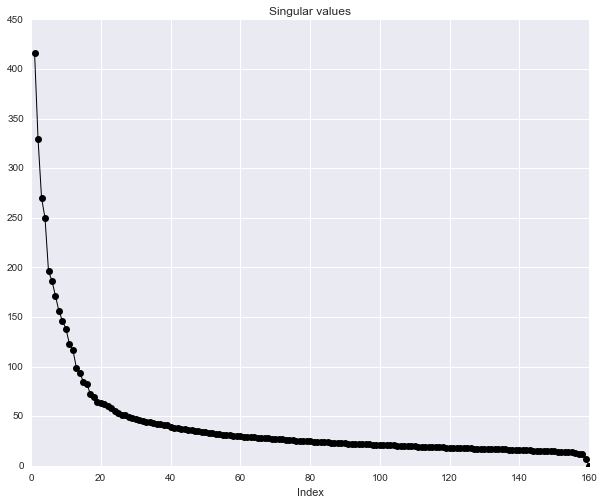

In [15]:
# Obtain the SVD:
# Note that u.dot(np.diag(s).dot(v)) == X_sc, so 
# v is *actually* what Python calls v^T! Be warned!
u, s, v = np.linalg.svd(X_sc, full_matrices = False)
Sigma = np.diag(s)
PCs = u.dot(Sigma)

# Plot singular values
fig = plt.figure(figsize=(10, 8))
sing_val_inds = np.arange(len(s)) + 1
plt.plot(sing_val_inds, s, 'ko-', linewidth=1)
plt.title('Singular values')
plt.xlabel('Index')
plt.show()

# Based on singular value scree plot,
# let's just keep the first 25 principal components's-worth of information.
X_pca_trans = X_sc.dot(v[0:25, ].T)

In [23]:
# Save data with zipped archive of files, .npz format
np.savez(path.join("data", "greeble_X_Y.npz"), X=X, Y=Y, mu=mean_vec)

## Visualization

Usually in the context of facial image decompositions, we're interested in the 'eigenfaces' resultant from a principal component decomposition... so we'll illustrate the 'eigengreeble' decompositions for our case. Each eigengreeble is just a column vector of the right singular vector matrix, $V$. Note that I take the rows of '$V$' due to the fact that Numpy's SVD implementation actually returns $V^{T}$ instead of $V$.

Eigengreebles are a set of new basis vectors, the vectors along which X displays the highest amount of variance! We can get a low-rank approximation to any greeble in our set of 160 greebles by combining only a few of these special basis greebles as opposed to using all 160. From the different eigengreebles plotted below, you can start to see how the greebles vary: the first eigengreeble might indicate variance in the shape of the head, the second one might indicate variance around the lower torso, etc...

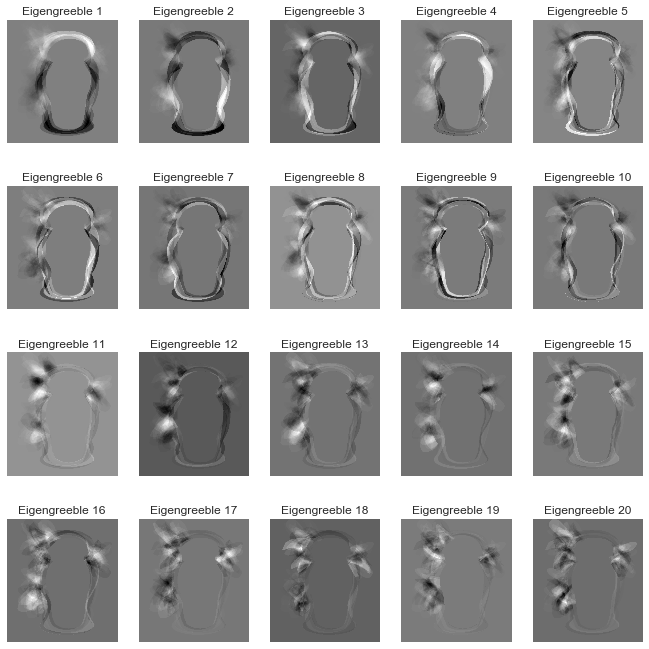

In [16]:
# Plot first 20 EigenGreebles (i.e. just reshaped basis vectors.)
plt.figure(figsize = [1.8*5, 2.4*4])
plt.subplots_adjust(bottom = 0, left = 0.01, right = 0.99, top = 0.9, hspace = 0.35)
for i in range(20):
    plt.subplot(4, 5, i + 1)
    basis_greeble = np.reshape(v[i,:], img_dim) ## Caution, see note above about V versus V^T.
    plt.imshow(np.reshape(basis_greeble, img_dim), cmap = plt.cm.gray)
    plt.title("Eigengreeble %d" % (i+1))
    plt.xticks([]); plt.yticks([]) 

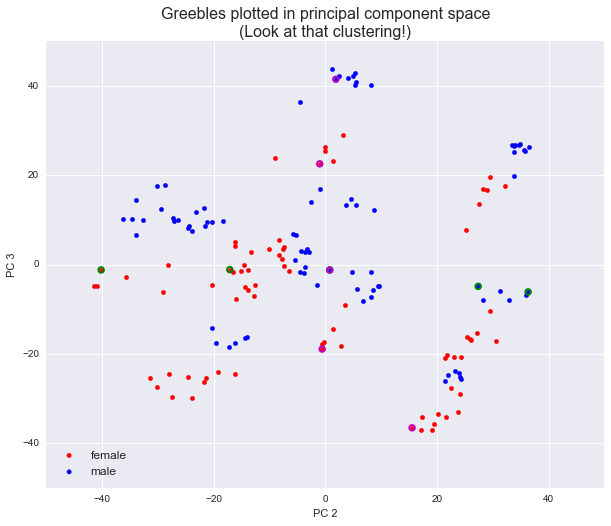

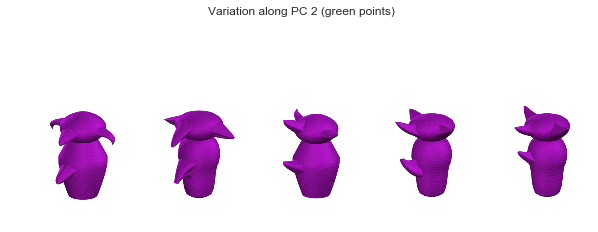

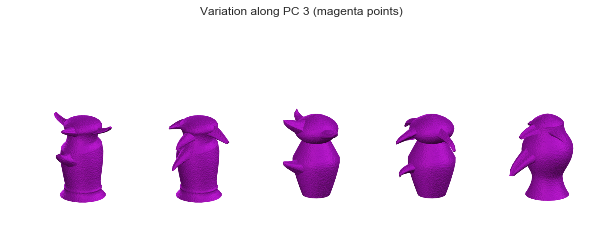

In [17]:
## Theoretically, if we wanted to plot a few low-rank representations of a particular greeble.
def low_rank_img(img_ind, d):
    '''
    Plot a low-rank approximation of a particular greeble: \sum_{j = 1}^{d} u_{i, j} \sigma_{j} v_{j} + \bar{\mu}
    
    img_ind: index of greeble for which we'll find a low-rank representation.
    d: dimensionality of low-rank greeble.
    '''
    im = np.zeros(shape = (v.shape[1],))
    for j in range(d):
        im = u[img_ind,j]*s[j]*v[j,:]
    im += mean_vec
    im = im.reshape(img_dim)
    plt.imshow(im*255, cmap = 'gray', interpolation = 'lanczos')
    plt.title("Rank-%d approximation of greeble %d" % (d, i))
    plt.xticks([]); plt.yticks([]) 

def Plot_nearest_to_grid(i, j):
    '''
    Plot greeble positions along the i-th PC vector vs. the j-th PC vector.
    Find greebles nearest the plotting grid intersection points.
    
    i: index of a principal component to use as x-axis.
    j: index of a principal component to use as y-axis.
    '''
    dat = np.transpose(np.array([PCs[:,i], PCs[:,j]]))
    horiz = np.transpose(np.array([np.linspace(-40, 40, 5), np.zeros([5])])) #(-40, 0), (-20, 0), etc...
    vert = np.transpose(np.array([np.zeros([5]), np.linspace(40, -40, 5)])) #(0, 40), (0, 20), etc...
    horizontal_imgs = []
    vertical_imgs = []
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1,1,1)
    fem = ax.scatter(PCs[np.where(Y == 0),i], PCs[np.where(Y == 0),j], color = "red")
    male = ax.scatter(PCs[np.where(Y == 1),i], PCs[np.where(Y == 1),j], color = "blue")
    
    ax.set_xlabel("PC %d" % i)
    ax.set_ylabel("PC %d" % j)
    ax.set_title("Greebles plotted in principal component space\n(Look at that clustering!)")
    ax.title.set_fontsize(16)
    ax.legend((fem, male),
           ("female", "male"),
           scatterpoints=1,
           loc='lower left',
           fontsize=12)
    
    for i in range(5):
            ptH = horiz[i,:]
            ptV = vert[i,:]
            horiz_greeb_ind = np.argmin([np.linalg.norm(ptH - dat[ii,:]) for ii in range(dat.shape[0])])
            vert_greeb_ind = np.argmin([np.linalg.norm(ptV - dat[ii,:]) for ii in range(dat.shape[0])])
            ax.scatter(dat[horiz_greeb_ind,0], dat[horiz_greeb_ind,1], s = 30, facecolors = 'none', edgecolors = 'g', linewidths = 2)
            ax.scatter(dat[vert_greeb_ind,0], dat[vert_greeb_ind,1], s = 30, facecolors = 'none', edgecolors = 'm', linewidths = 2)
            horizontal_imgs.append(horiz_greeb_ind); vertical_imgs.append(vert_greeb_ind)
    
    plt.show()
    return(horizontal_imgs, vertical_imgs)


i = 2; j = 3
horiz, vert = Plot_nearest_to_grid(i,j)

# Attempt to illustrate how the greebles change along particular principal components...
fig = plt.figure(figsize = (10,8))
fig.suptitle('Variation along PC %d (green points)'%i)
for i in range(5):
    ax = fig.add_subplot(2,5, i+1)
    img = cv2.imread(path.join(cwd, 'data', greeble_imgs[horiz[i]]), cv2.IMREAD_COLOR)
    ax.imshow(img)
    ax.axis("off")

fig = plt.figure(figsize = (10,8))
fig.suptitle('Variation along PC %d (magenta points)'%j)
for i in range(5):
    ax = fig.add_subplot(2,5, i+1)
    img = cv2.imread(path.join(cwd, 'data', greeble_imgs[vert[i]]), cv2.IMREAD_COLOR)
    ax.imshow(img)
    ax.axis("off")

## Non-negative matrix factorization (NMF)

NMF is a type of matrix factorization (recall that the SVD is similarly a matrix factorization as well) suited particularly for non-negative data matrices, $X$ - thus, NMF is often applied in the context of image learning (because pixel intensities are strictly non-negative) or text document learning (as word counts are also strictly non-negative).

The factorization is this: $$X = WH$$

If $X$ has $n$ rows and $m$ features, then $W$ is an $(n, d)$ matrix, and $H$ is a $(d, m)$ matrix, where $d$ is some number $d \le m$. In this way, NMF can get us to a different 'low-rank' approximation to $X$ that gets us out of the $n<<p$ problem pointed out in the beginning of this post. You can think of the rows of $H$ as greeble *archetypes* while the columns of $W$ are the coefficients used to combine different archetypes into approximations of specific greebles.

#### Archetypes are different than eigengreebles

With PCA, each eigengreeble is a linear combination of all column vectors in $X$.
With Scikit Learn, an NMF model object contains a Numpy array called ** .components_**, which is the $H$ matrix. The basis vectors that the NMF gets us correspond to actual parts, facets of the greebles themselves (e.g. the shape of their bases, or the girth of their torsos) as opposed to being linear combinations of the column vectors of $X$. Thus, the basis found in an NMF model are *sparse* bases, unlike the PCA basis, and bases are combined additively (all coefficients in $W$ are positive), whereas PCA bases can be added and subtracted when approximating a greeble.

In [18]:
## Fit NMF model using 25 archetypal greebles
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=25, init='random', random_state=0)
nmf_model.fit(X) 

nmf_model.components_.shape

(25, 115200)

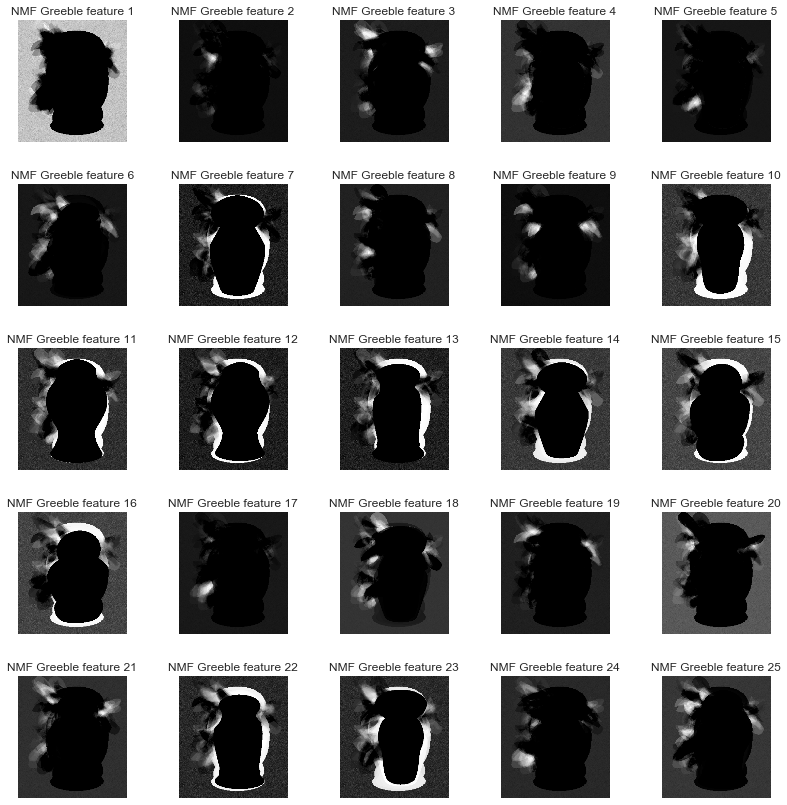

In [19]:
# Plot first 30 NMF bases
plt.figure(figsize = [1.8*6, 2.4*5])
plt.subplots_adjust(bottom = 0, left = 0.05, right = 1.05, top = 0.9, hspace = 0.35)
for i in range(25):
    plt.subplot(5,5, i + 1)
    basis_greeble = np.reshape(nmf_model.components_[i,:], img_dim)
    plt.imshow(np.reshape(basis_greeble, img_dim), cmap = plt.cm.gray)
    plt.title("NMF Greeble feature %d" % (i+1))
    plt.xticks([]); plt.yticks([]) 

In [20]:
# Find each greeble's composition of NMF bases.
# NOTE: we did not fit or transform the de-meaned data matrix,
# as that would have brought negative values into the data.
X_nmf_trans = nmf_model.transform(X) 
X_nmf_trans.shape

(160, 25)